It's the same sample of "[Image Recognition](https://github.com/annemacena/pytorch-crash-course/blob/master/Image_Recognition.ipynb)" but using CNN

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
'''
  * transforms.ToTensor() will convert the numpy array (with a range of 0 to 255) to a float tensor (with the range of 0 to 1)

  * transforms.Normalize((0.5,), (0.5,)) specifies the mean and the deviation that would be used to normalize all channels of the tensor image
      Normalization does the following for each channel: image = (image - mean) / std.
      The value 0.5 was choose in this case cause the autor wanted to normalize the image in the range [-1,1].
      For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.

      Normalization helps reducing the skewness and distortions.
'''
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

'''
  The DataLoader combine a dataset object along with different samplers (different strategies for providing data to algorithms) 
  and provides a batch (set of samples used in a interaction) of images.

  * gradient descent algorithms tend to get stuck in local minima, 
    so if you suffle your training data, you ensure that the subset changes with every single iterations.
'''
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0) # [1, 28, 28] to [28, 28, 1]
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # normalization
  image = image.clip(0, 1)
  return image

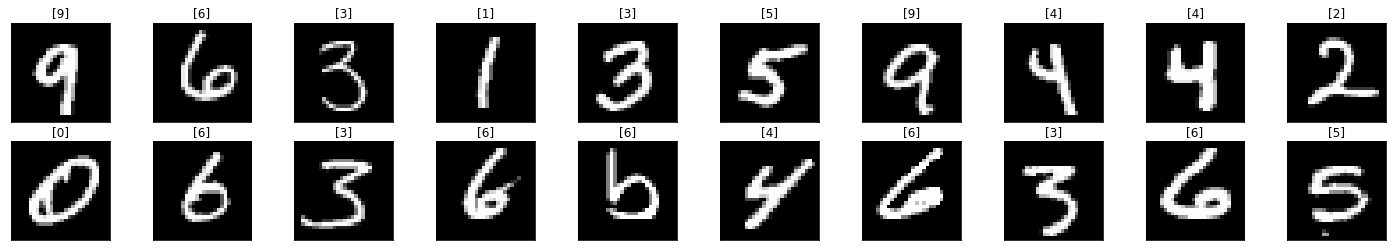

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(4*4*50, 500)
      #self.dropout1 = nn.Dropout(0.5) # used to reduce outfitting
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      #x = self.dropout1(x) # used to reduce outfitting
      x = self.fc2(x)
      return x

In [0]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.5053, acc 87.3067 
validation loss: 0.1471, validation acc 95.8100 
epoch : 2
training loss: 0.1187, acc 96.4650 
validation loss: 0.0839, validation acc 97.4600 
epoch : 3
training loss: 0.0786, acc 97.6517 
validation loss: 0.0613, validation acc 98.0600 
epoch : 4
training loss: 0.0610, acc 98.1467 
validation loss: 0.0520, validation acc 98.3600 
epoch : 5
training loss: 0.0512, acc 98.4117 
validation loss: 0.0412, validation acc 98.5900 
epoch : 6
training loss: 0.0440, acc 98.6783 
validation loss: 0.0373, validation acc 98.7500 
epoch : 7
training loss: 0.0383, acc 98.7917 
validation loss: 0.0345, validation acc 98.8600 
epoch : 8
training loss: 0.0330, acc 99.0050 
validation loss: 0.0333, validation acc 98.8600 
epoch : 9
training loss: 0.0295, acc 99.0983 
validation loss: 0.0355, validation acc 98.8400 
epoch : 10
training loss: 0.0268, acc 99.1950 
validation loss: 0.0287, validation acc 99.0000 
epoch : 11
training loss: 0.0242, acc 99.2800 
va

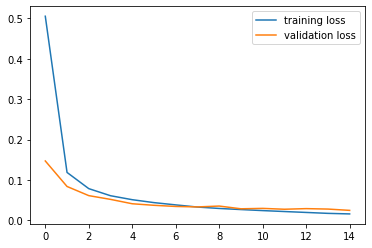

In [0]:
'''
  the training loss became less than validation loss, causing overfitting
  (Overfitting means that the neural network models the training data too well and fails when it faces new and yet unseen data)
'''
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

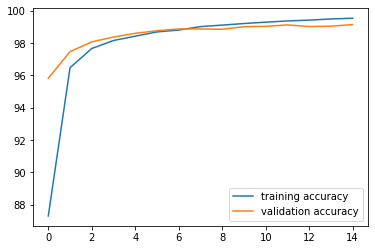

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

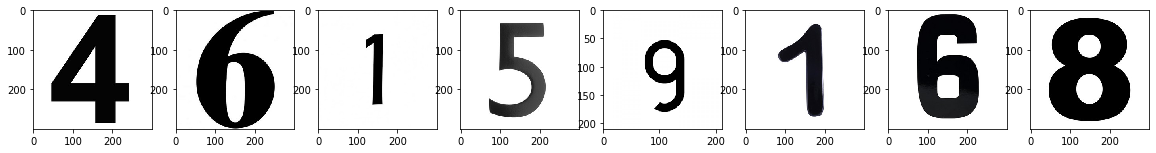

In [0]:
import PIL.ImageOps
import requests
from PIL import Image

urls = ['https://i.postimg.cc/C1ymcjh8/4.jpg', 'https://i.postimg.cc/brpLhp2N/4a0dbee4baf35aea8832838b2a8700c6.jpg',
        'https://i.postimg.cc/76gXdfhW/adesivo-de-numeracao-individual-05x09-numero-1-002801-01.jpg',
        'https://i.postimg.cc/qqwwBS8c/architectural-mailboxes-house-letters-numbers-3585b-5-64-1000.jpg',
        'https://i.postimg.cc/3rFnZ4Py/images.png', 'https://i.postimg.cc/wTxF4xpw/numero-1-preto-ceramica-esmaltada-numeros-residenciais.jpg',
        'https://i.postimg.cc/wTW2CKxg/pictures-of-number-6-43.jpg', 'https://i.postimg.cc/BnXpshtD/s-l1600.jpg']

columns = len(urls)
imgs = []

fig = plt.figure(figsize=(20, 4))

for idx in range(0, columns):
  response = requests.get(urls[idx], stream = True)
  img = Image.open(response.raw)
  fig.add_subplot(1, columns, idx+1)
  imgs.append(img)
  plt.imshow(img)

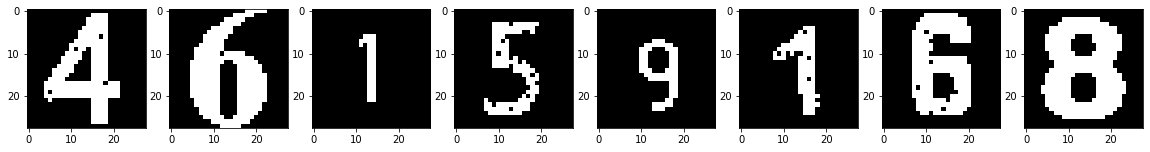

In [0]:
inverted_imgs = []
fig = plt.figure(figsize=(20, 4))

for idx in range(0, columns):
  img = PIL.ImageOps.invert(imgs[idx])
  img = img.convert('1')
  img = transform(img)
  inverted_imgs.append(img)
  fig.add_subplot(1, columns, idx+1)
  plt.imshow(im_convert(img))

In [0]:
for idx in range(0, columns):
  img = inverted_imgs[idx].to(device)
  img = img.unsqueeze(0)
  output = model(img)
  _, pred = torch.max(output, 1)
  print(pred.item(), end=" ")

4 5 1 5 9 1 6 8 

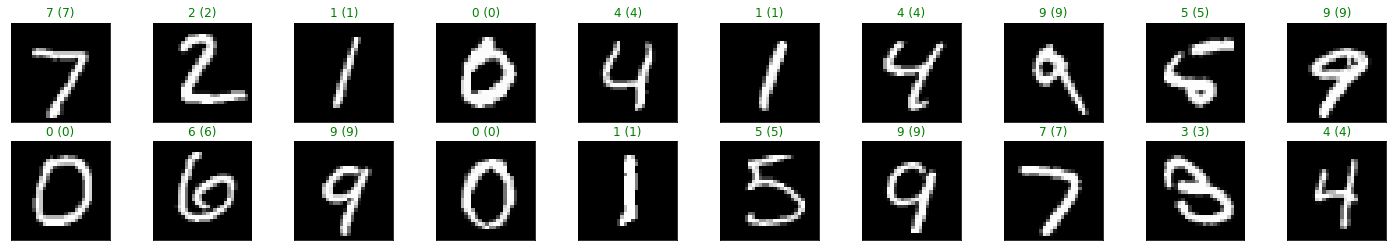

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))